In [5]:
%load_ext autoreload
%autoreload 2

In [104]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import iqr

In [139]:
def make_q_learning_plots(data_file_path, param_name, output_name=None):
    p = Path(data_file_path)

    frames = []

    for x in p.iterdir():
        s = x.name.split("_")
        size = s[1]
        param = s[4].split(":")[1].split("-")[0]
        trial = s[4].split(":")[1].split("-")[1].split(".")[0]
        df = pd.read_csv(x)
        df["size"] = size
        df[param_name] = param
        df["trial"] = trial
        frames.append(df)

    df = pd.concat(frames, ignore_index=True).sort_values(by=["size", param_name, "trial", "iter"])

    size_map = {"sm": 0, "lrg": 1}
    size_to_title_map = {"sm": "Small", "lrg": "Large"}
    metric_map = {"numSteps": 0, "maxQChangeInLastEpisode": 1, "wallclock": 2}

    fig, axs = plt.subplots(3, 2, figsize=(9, 6.5), tight_layout=True)
    plt.rcParams['text.usetex'] = True

    rolled = []
    for (param,size,trial), data in df.groupby([param_name,"size","trial"]):
        for metric in ["numSteps", "maxQChangeInLastEpisode", "wallclock"]:
            if metric != "wallclock":
                data[metric] = data[metric].rolling(window=3, center=True).mean()
            else:
                data[metric] = np.cumsum(1e-9 * data[metric])
        data[param_name] = param
        data["size"] = size
        data["trial"] = trial
        rolled.append(data)
    rolled_df = pd.concat(rolled, ignore_index=True)
    
    metric_to_title_map = {"maxQChangeInLastEpisode": "$\Delta$ maxQ", "wallclock": "Cumulative Wallclock (s)"}

    agged = rolled_df.groupby(["iter", param_name, "size"], as_index=False).agg(
        {"numSteps": ["median", iqr], "maxQChangeInLastEpisode": ["median", iqr], "wallclock": ["median", iqr]})
    for (size,param), data in agged.groupby(["size", param_name]):
        for metric in ["numSteps", "maxQChangeInLastEpisode", "wallclock"]:
            ax = axs[metric_map[metric]][size_map[size]]
            x = data["iter"]
            y = data[metric]["median"].rolling(window=5, center=True).mean()
            ax.plot(x, y, label=f"$\\{param_name}: {param}$")
            # ax.fill_between(x, y+d, y-d, alpha=0.1)
            ax.set_title(f"{metric_to_title_map.get(metric, metric)} - {size_to_title_map[size]}")
            ax.set_xlabel("Iteration")
            ax.legend()

    if output_name:
        plt.savefig(output_name, dpi=500)
    else:
        plt.savefig(f"figures/BlockDude_Q_Learning_{param_name}.png", dpi=500)

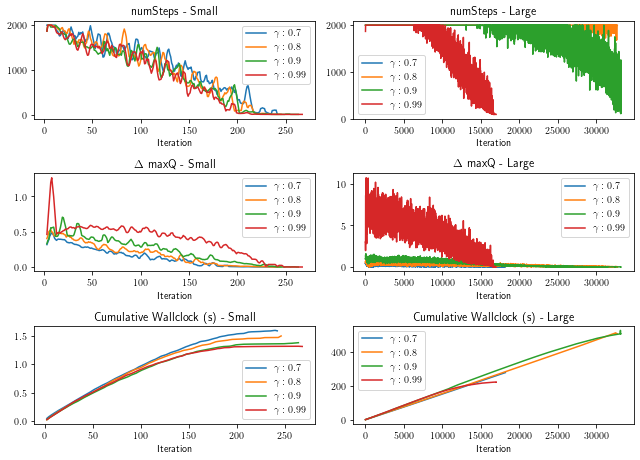

In [140]:
make_q_learning_plots("../cs7641-hw4.2/output/smprob-26075656/blockdude", "gamma", "figures/BlockDude_Q_Learning_gamma_2.png")

# Table

In [110]:
pd.set_option('display.float_format', '{:.2E}'.format)
# pd.reset_option('display.float_format')
frames = []

df["wallclock_cumsum"] = np.cumsum(df["wallclock"])
table = (df
 .merge(df.groupby(["gamma","size","trial"], as_index=False)["iter"].max(),
        on=["gamma","size","trial","iter"])
 .groupby(["size","gamma"])
     .agg({"numSteps": ["median", iqr],
           "wallclock_cumsum": ["median", iqr],
           "iter": ["median", iqr]})
)

print(table.to_latex())
# for (gamma,size), data in df.groupby(["gamma","size"]):
# 
# (df
#  .groupby(["gamma","size"], as_index=False)
#  .agg({"numSteps": ["median",iqr]})
#  .sort_values(["size","gamma"])
# )

\begin{tabular}{llrrrrrr}
\toprule
   &      & \multicolumn{2}{l}{numSteps} & \multicolumn{2}{l}{wallclock\_cumsum} & \multicolumn{2}{l}{iter} \\
   &      &   median &      iqr &           median &      iqr &   median &      iqr \\
size & gamma &          &          &                  &          &          &          \\
\midrule
lrg & 0.7 & 2.00E+03 & 0.00E+00 &         2.87E+10 & 1.37E+10 & 8.71E+02 & 5.50E+00 \\
   & 0.8 & 2.00E+03 & 0.00E+00 &         1.39E+11 & 4.79E+10 & 3.01E+03 & 3.20E+01 \\
   & 0.9 & 9.40E+01 & 4.70E+01 &         1.11E+12 & 2.29E+11 & 3.27E+04 & 1.64E+04 \\
   & 0.99 & 9.40E+01 & 4.70E+01 &         1.52E+12 & 1.00E+11 & 1.69E+04 & 8.46E+03 \\
sm & 0.7 & 1.90E+01 & 0.00E+00 &         1.52E+12 & 1.67E+09 & 2.25E+02 & 7.50E+00 \\
   & 0.8 & 1.90E+01 & 9.50E+00 &         1.52E+12 & 8.14E+08 & 2.37E+02 & 1.21E+02 \\
   & 0.9 & 1.90E+01 & 9.50E+00 &         1.53E+12 & 8.42E+08 & 2.59E+02 & 1.30E+02 \\
   & 0.99 & 1.90E+01 & 9.50E+00 &         1.53E+12 & 7.15E+08 & 

# Epsilon

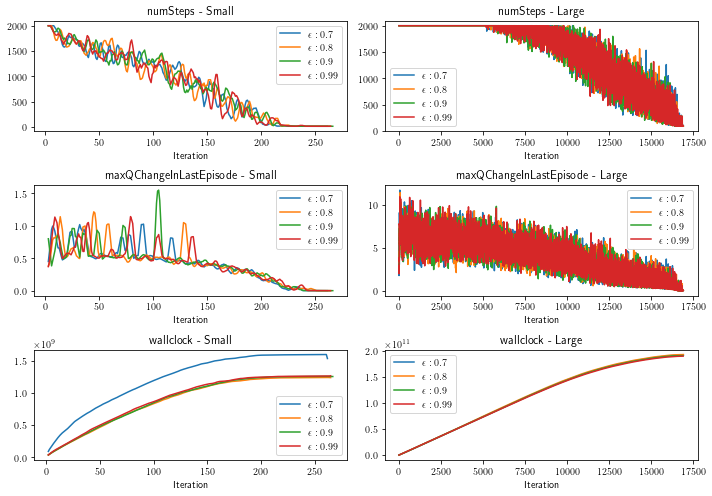

In [133]:
data_file_path = "../cs7641-hw4.2/output/smprob-25213333/blockdude"

make_q_learning_plots(data_file_path, "epsilon")

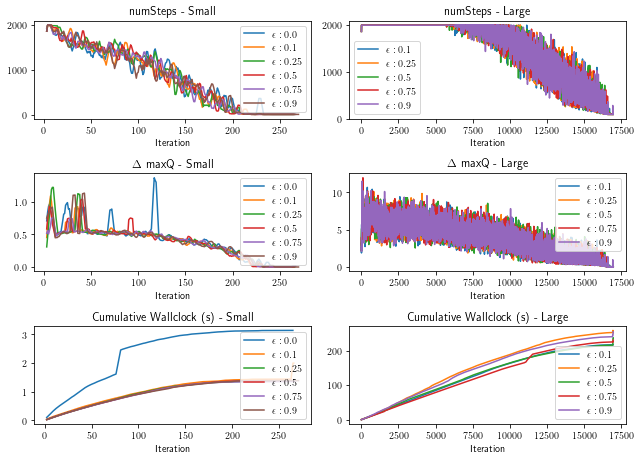

In [152]:
make_q_learning_plots("../cs7641-hw4.2/output/smprob-26091010/blockdude", "epsilon", "figures/BlockDude_Q_Learning_epsilon_2.png")

# Alpha

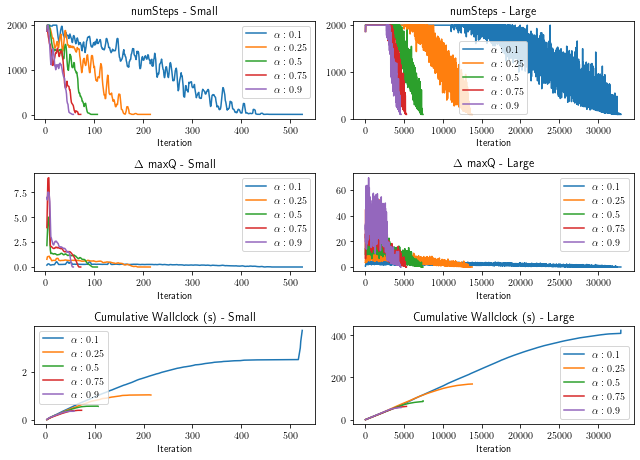

In [141]:
make_q_learning_plots("../cs7641-hw4.2/output/smprob-26130000/blockdude", "alpha")

In [145]:
df

,iter,numSteps,wallclock,maxQChangeInLastEpisode,size,alpha,trial,wallclock_cumsum
91260,0,2000,19826571,1.404435e-01,lrg,0.1,00,0.019827
91261,1,2000,19640066,1.305097e+00,lrg,0.1,00,0.039467
91262,2,2000,19467677,1.062558e-01,lrg,0.1,00,0.058934
91263,3,2000,20309067,2.374485e+00,lrg,0.1,00,0.079243
91264,4,2000,19579382,1.200293e-01,lrg,0.1,00,0.098823
...,...,...,...,...,...,...,...,...
52478,56,19,153109,4.458142e-03,sm,0.9,02,2384.864996
52479,57,19,289572,4.853350e-04,sm,0.9,02,2384.865286
52480,58,19,268043,5.465462e-05,sm,0.9,02,2384.865554
52481,59,19,205810,6.460997e-06,sm,0.9,02,2384.865759


In [151]:
data_file_path = "../cs7641-hw4.2/output/smprob-26130000/blockdude"

param_name = "alpha"

p = Path(data_file_path)

frames = []

for x in p.iterdir():
    s = x.name.split("_")
    size = s[1]
    param = s[4].split(":")[1].split("-")[0]
    trial = s[4].split(":")[1].split("-")[1].split(".")[0]
    df = pd.read_csv(x)
    df["size"] = size
    df[param_name] = param
    df["trial"] = trial
    frames.append(df)

df = pd.concat(frames, ignore_index=True).sort_values(by=["size", param_name, "trial", "iter"])

pd.set_option('display.float_format', '{:,.2f}'.format)
# pd.reset_option('display.float_format')
frames = []

for (param,size,trial), data in df.groupby([param_name,"size","trial"]):
    data["wallclock_cumsum"] = np.cumsum(1e-9 * data["wallclock"])
    data[param_name] = param
    data["size"] = size
    data["trial"] = trial
    frames.append(data)


table = (pd.concat(frames, ignore_index=True)
 .merge(df.groupby([param_name,"size","trial"], as_index=False)["iter"].max(),
        on=[param_name,"size","trial","iter"])
 .groupby(["size", param_name])
     .agg({"numSteps": ["median", iqr],
           "wallclock_cumsum": ["median", iqr],
           "iter": ["median", iqr]})
)

print(table.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
   &     & \multicolumn{2}{l}{numSteps} & \multicolumn{2}{l}{wallclock\_cumsum} & \multicolumn{2}{l}{iter} \\
   &     &   median &  iqr &           median &   iqr &    median &   iqr \\
size & alpha &          &      &                  &       &           &       \\
\midrule
lrg & 0.1 &    94.00 & 0.00 &           409.43 & 14.99 & 32,947.00 &  4.00 \\
   & 0.25 &    94.00 & 0.00 &           168.80 &  1.48 & 13,754.00 & 14.00 \\
   & 0.5 &    94.00 & 0.00 &            85.45 &  2.31 &  7,404.00 & 14.50 \\
   & 0.75 &    94.00 & 0.00 &            62.76 &  0.79 &  5,286.00 &  2.00 \\
   & 0.9 &    94.00 & 0.00 &            57.34 &  0.83 &  4,571.00 &  3.00 \\
sm & 0.1 &    19.00 & 0.00 &             2.51 &  0.75 &    523.00 &  4.00 \\
   & 0.25 &    19.00 & 0.00 &             1.05 &  0.04 &    216.00 &  1.50 \\
   & 0.5 &    19.00 & 0.00 &             0.58 &  0.05 &    108.00 &  0.50 \\
   & 0.75 &    19.00 & 0.00 &             0.41 &  0.02 &     74.00 &

In [153]:
table

numSteps      wallclock_cumsum            iter      
             median  iqr           median   iqr    median   iqr
size alpha                                                     
lrg  0.1      94.00 0.00           409.43 14.99 32,947.00  4.00
     0.25     94.00 0.00           168.80  1.48 13,754.00 14.00
     0.5      94.00 0.00            85.45  2.31  7,404.00 14.50
     0.75     94.00 0.00            62.76  0.79  5,286.00  2.00
     0.9      94.00 0.00            57.34  0.83  4,571.00  3.00
sm   0.1      19.00 0.00             2.51  0.75    523.00  4.00
     0.25     19.00 0.00             1.05  0.04    216.00  1.50
     0.5      19.00 0.00             0.58  0.05    108.00  0.50
     0.75     19.00 0.00             0.41  0.02     74.00  0.50
     0.9      19.00 0.00             0.37  0.04     58.00  2.00

In [155]:
57 * 1e6

57000000.0